# Introduction
A very important aspect of supervised and semi-supervised machine learning is the quality of the labels produced by human labelers. Unfortunately, humans are not perfect and in some cases may even maliciously label things incorrectly. In this assignment, you will evaluate the impact of incorrect labels on a number of different classifiers.

We have provided a number of code snippets you can use during this assignment. Feel free to modify them or replace them.


## Dataset
The dataset you will be using is the [Adult Income dataset](https://archive.ics.uci.edu/ml/datasets/Adult). This dataset was created by Ronny Kohavi and Barry Becker and was used to predict whether a person's income is more/less than 50k USD based on census data.

### Data preprocessing
Start by loading and preprocessing the data. Remove NaN values, convert strings to categorical variables and encode the target variable (the string <=50K, >50K in column index 14).

In [528]:
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

#### Loading the data

In [529]:
# changed header=None to header=0, so that it automatically assigns the column names
data = pd.read_csv("adult.csv", header=0, na_values='?')
data.shape

(48842, 15)

In [530]:
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [531]:
# observe the unique values
def get_unique_values(data):
    output_data = []
    
    for col in data.columns:
        if data.loc[:, col].nunique() <= 10:
            unique_values = data.loc[:, col].unique()
            
            output_data.append([col, data.loc[:, col].nunique(), unique_values, data.loc[:, col].dtype])
        else:
            output_data.append([col, data.loc[:, col].nunique(), "-", data.loc[:, col].dtype])
            
        output_df = pd.DataFrame(output_data, columns=['Column Name', 'Number of Unique Values', 'Unique Values ', 'Data Type'])
    
    return output_df

In [532]:
get_unique_values(data)

,Column Name,Number of Unique Values,Unique Values,Data Type
0,age,74,-,int64
1,workclass,8,"[State-gov, Self-emp-not-inc, Private, Federal...",object
2,fnlwgt,28523,-,int64
3,education,16,-,object
4,education-num,16,-,int64
5,marital-status,7,"[Never-married, Married-civ-spouse, Divorced, ...",object
6,occupation,14,-,object
7,relationship,6,"[Not-in-family, Husband, Wife, Own-child, Unma...",object
8,race,5,"[White, Black, Asian-Pac-Islander, Amer-Indian...",object
9,sex,2,"[Male, Female]",object


## Cleaning the Data

In [533]:
# Convert to categorical variables
def convert_categorical(data):
    for column in data.columns:
        if data[column].dtype == object:
            data[column] = data[column].astype('category')

In [534]:
convert_categorical(data)

In [535]:
data.dtypes

age                  int64
workclass         category
fnlwgt               int64
education         category
education-num        int64
marital-status    category
occupation        category
relationship      category
race              category
sex               category
capital-gain         int64
capital-loss         int64
hours-per-week       int64
native-country    category
salary            category
dtype: object

#### Encoding the target variable (salary)

In [536]:
# Encode the target variable
def encode_target_var(data, target_var):
    salary_mapping = {'<=50K': 0, '>50K': 1, '<=50K.': 0, '>50K.': 1}
    data[target_var] = data[target_var].map(salary_mapping)

In [537]:
# encoding the target variable
encode_target_var(data, 'salary')

In [538]:
data.sample(3)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
28274,24,Private,130741,Bachelors,13,Never-married,Sales,Own-child,White,Male,0,0,40,United-States,0
9796,39,Private,74194,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,55,United-States,0
45672,55,Self-emp-not-inc,79011,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,Asian-Pac-Islander,Male,0,0,70,United-States,0


In [539]:
# Check if the encoding went well
data['salary'].unique()

array([0, 1], dtype=int64)

In [540]:
# Extracting numerical and categorical columns
numerical_features = data.select_dtypes(include=['int64', 'float64']).drop(['salary'], axis=1).columns
categorical_features = data.select_dtypes(include=['category']).columns

In [541]:
# Distributions of Categorical Features
def plot_categorical_distribution(data, categorical_features):
    for column in categorical_features:
        plt.figure(figsize=(8, 6))
        ax = sns.countplot(x = column, data=data, palette='BuPu')
        plt.title(f'Distribution of Categories {column}')
        
        ax.bar_label(ax.containers[0])
        
        plt.xticks(rotation=90)
        plt.show()
        
def plot_category(data, category_name):
    plt.figure(figsize=(15, 5))
    ax = sns.countplot(data=data, x=category_name, hue="salary", palette='BuPu')
    
    ax.bar_label(ax.containers[0])
    ax.bar_label(ax.containers[1])
    plt.show()

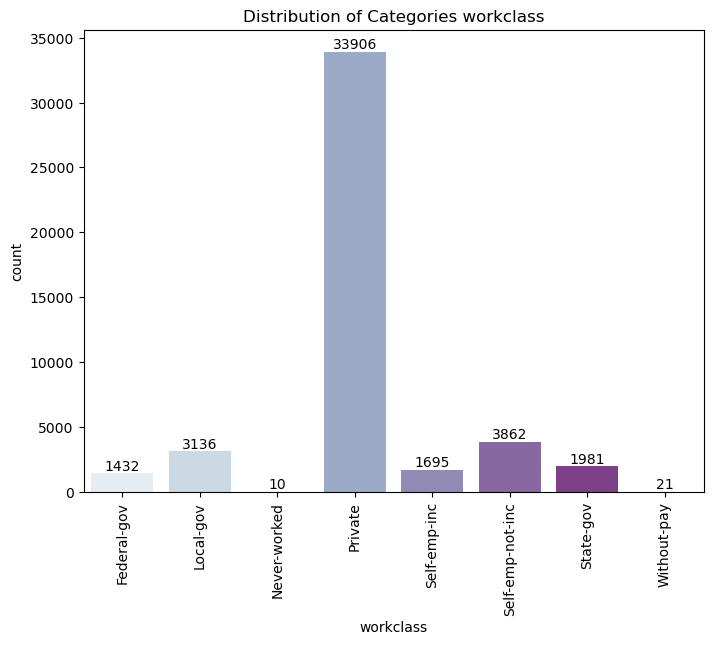

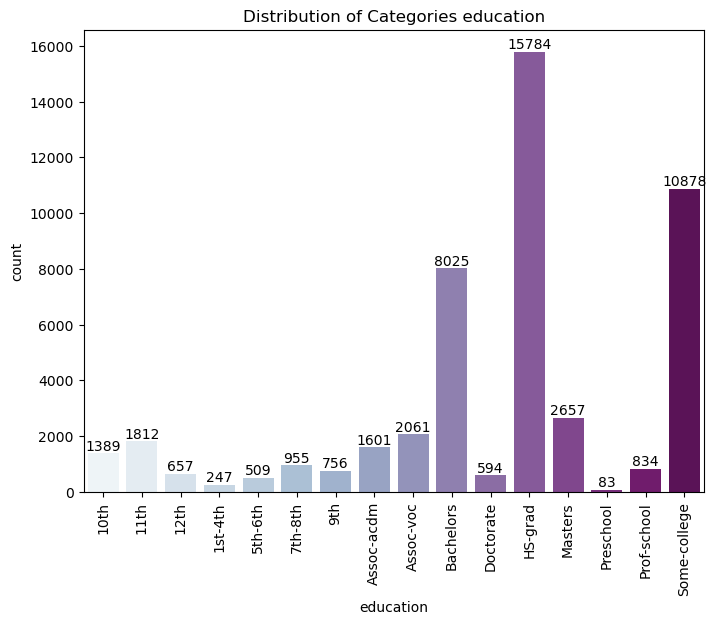

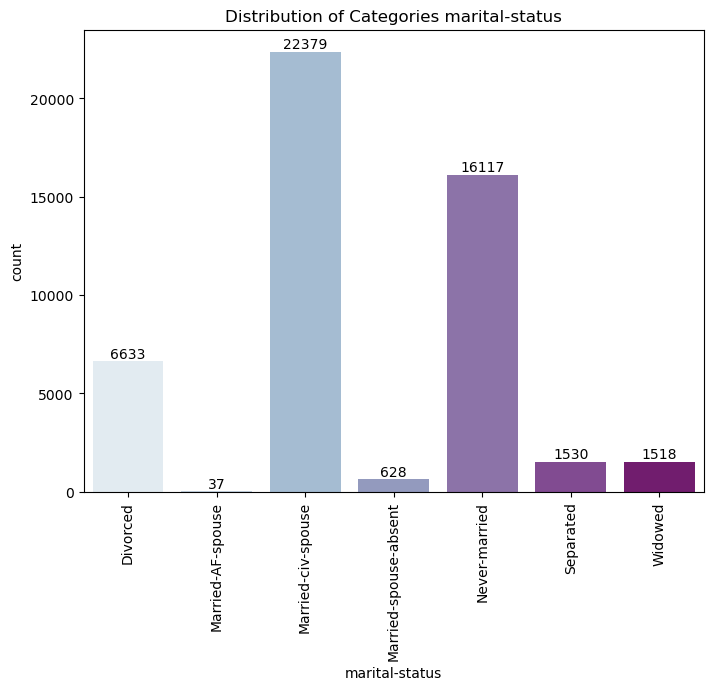

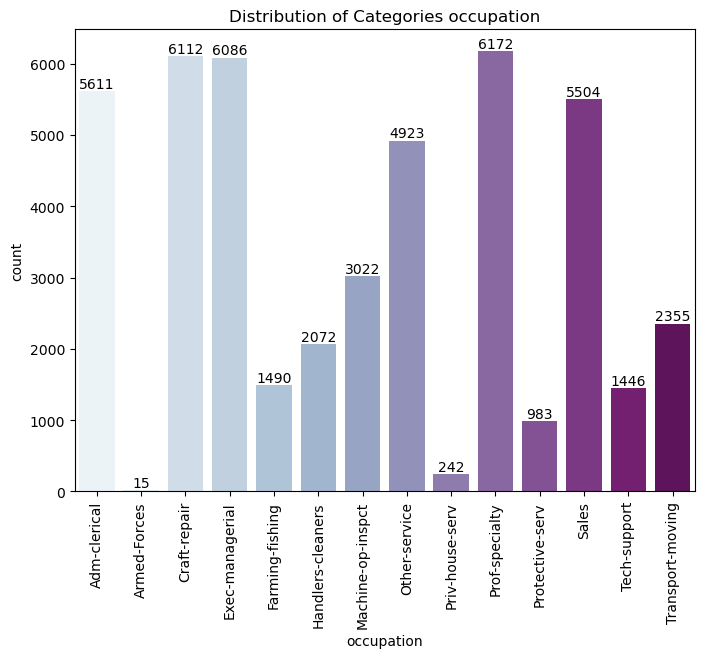

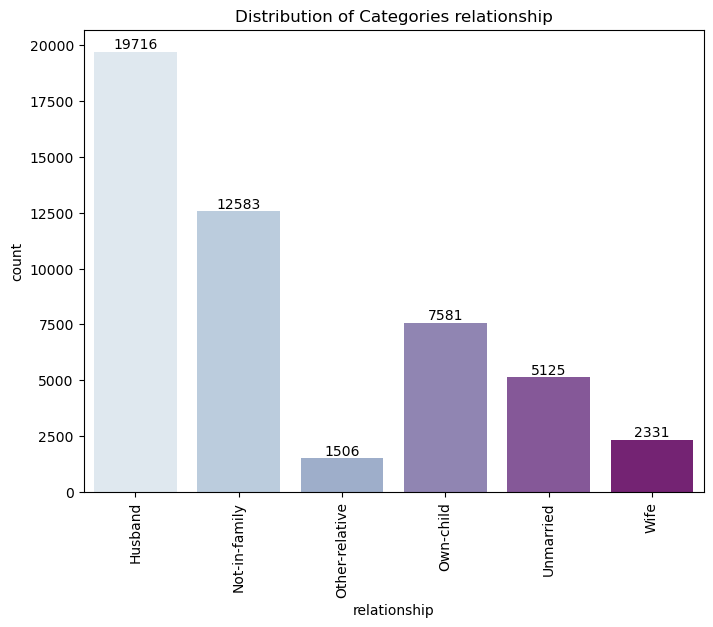

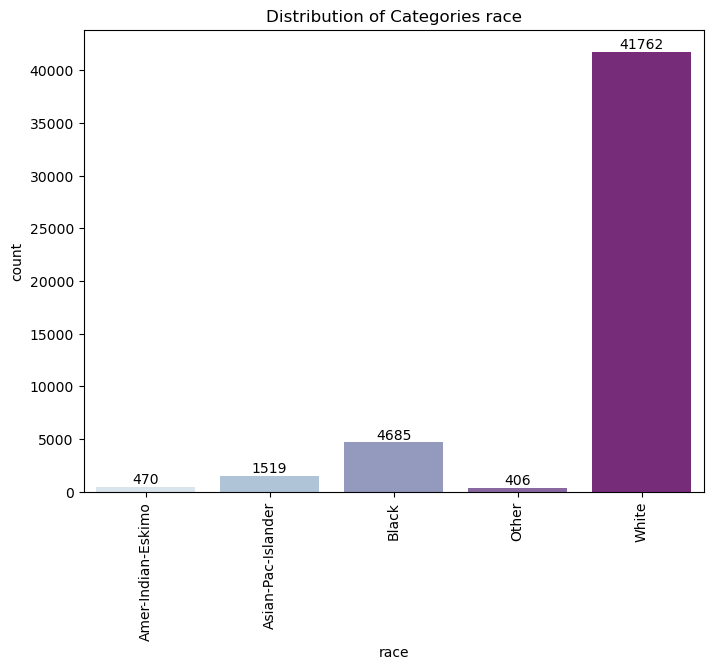

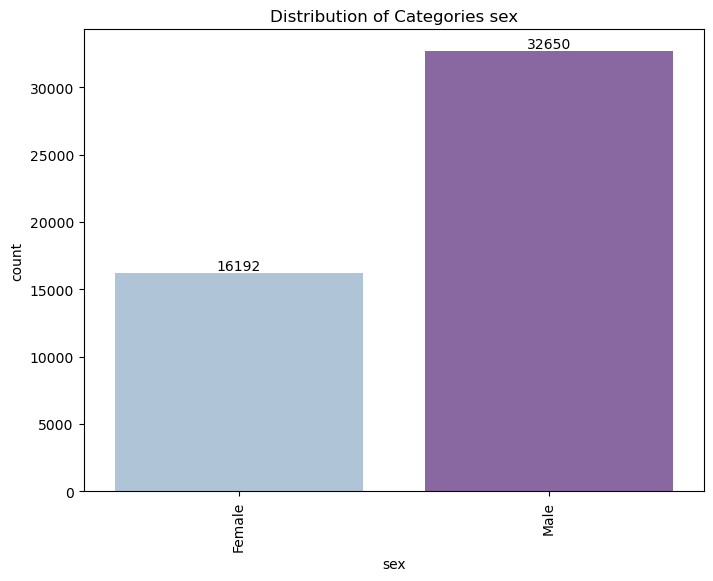

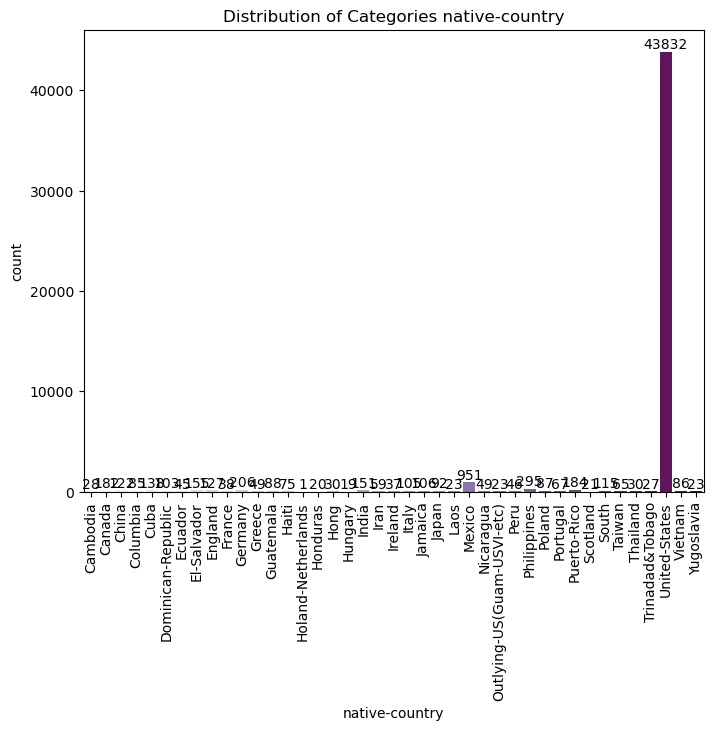

In [542]:
plot_categorical_distribution(data, categorical_features)

### Note
- Since the majority of the data is from the United States, grouping all other countries into a single "Others" category reduces the complexity of handling numerous country categories, many of which have very few entries.
- Similarly, in the Education column, grouping education levels into broader and cleaner categories will help reduce data complexity

In [543]:
# Grouping the Eduction Columnn to simplify analysis by reducing the number of unique categories
data['education'].replace(['1st-4th', '5th-6th'], 'Primary', inplace=True)
data['education'].replace(['7th-8th', '9th', '10th', '11th', '12th'], 'Middle-School', inplace=True)
data['education'].replace(['HS-grad'], 'High-School', inplace=True)
data['education'].replace(['Some-college', 'Assoc-voc', 'Assoc-acdm'], 'College', inplace=True)
data['education'].replace(['Bachelors'], 'Bachelors', inplace=True)
data['education'].replace(['Prof-school', 'Doctorate'], 'Doctorate', inplace=True)

# Grouping the Native Country column, all values that are not 'United-states' with 'Others'
data['native-country'] = data['native-country'].cat.add_categories('Others')
data['native-country'].loc[data['native-country'] != 'United-States'] = 'Others'
data['native-country'] = data['native-country'].cat.remove_unused_categories()

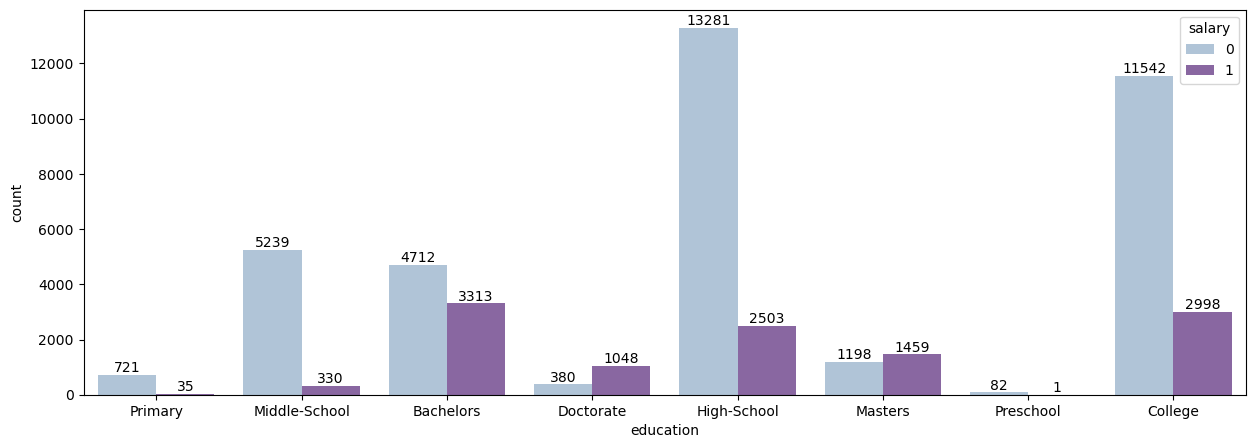

In [544]:
plot_category(data, 'education')

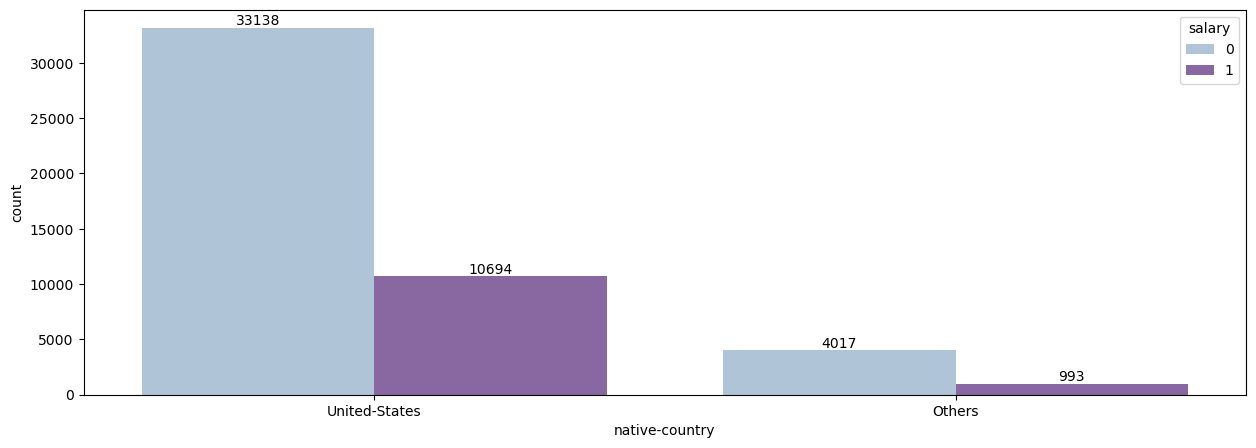

In [545]:
plot_category(data, 'native-country')

In [546]:
data.shape

(48842, 15)

In [547]:
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,High-School,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,Middle-School,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Others,0


In [548]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [549]:
numerical_features

Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')

In [550]:
ordinal_categories = ['education']
onehot_categories = categorical_features.drop('education')

In [551]:
# Split the data into training and test sets
X = data.drop('salary', axis=1)
y = data['salary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [552]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

categoric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('ordinal', OrdinalEncoder())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categoric_transformer, onehot_categories),
        ('ord', ordinal_transformer, ordinal_categories)
    ]
)

In [553]:
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

In [554]:
X_train_transformed.shape, X_test_transformed.shape

((39073, 53), (9769, 53))

In [555]:
features = preprocessor.get_feature_names_out()

# Get transformed dataframe for X_train
X_train_df = pd.DataFrame.sparse.from_spmatrix(X_train_transformed, columns=features, index=X_train.index)
X_train_df.head()

,num__age,num__fnlwgt,num__education-num,num__capital-gain,num__capital-loss,num__hours-per-week,cat__workclass_Federal-gov,cat__workclass_Local-gov,cat__workclass_Never-worked,cat__workclass_Private,...,cat__race_Amer-Indian-Eskimo,cat__race_Asian-Pac-Islander,cat__race_Black,cat__race_Other,cat__race_White,cat__sex_Female,cat__sex_Male,cat__native-country_Others,cat__native-country_United-States,ord__education
37193,0.205479,0.026025,0.533333,0.0,0.0,0.397959,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,3.0
31093,0.383562,0.089348,0.866667,0.0,0.0,0.397959,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,4.0
33814,0.246575,0.162323,0.466667,0.0,0.0,0.397959,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,5.0
14500,0.643836,0.038725,0.533333,0.0,0.0,0.193878,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,3.0
23399,0.630137,0.011046,0.533333,0.0,0.0,0.704082,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,3.0


In [556]:
# Get transformed dataframe for X_test
X_test_df = pd.DataFrame.sparse.from_spmatrix(X_test_transformed, columns=features, index=X_test.index)
X_test_df.head()

,num__age,num__fnlwgt,num__education-num,num__capital-gain,num__capital-loss,num__hours-per-week,cat__workclass_Federal-gov,cat__workclass_Local-gov,cat__workclass_Never-worked,cat__workclass_Private,...,cat__race_Amer-Indian-Eskimo,cat__race_Asian-Pac-Islander,cat__race_Black,cat__race_Other,cat__race_White,cat__sex_Female,cat__sex_Male,cat__native-country_Others,cat__native-country_United-States,ord__education
7762,0.013699,0.277880,0.533333,0.0,0.0,0.193878,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,3.0
23881,0.000000,0.112757,0.466667,0.0,0.0,0.193878,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,5.0
30507,0.109589,0.227791,0.533333,0.0,0.0,0.397959,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,3.0
28911,0.041096,0.139319,0.600000,0.0,0.0,0.295918,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
19484,0.410959,0.156781,0.533333,0.0,0.0,0.561224,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,3.0


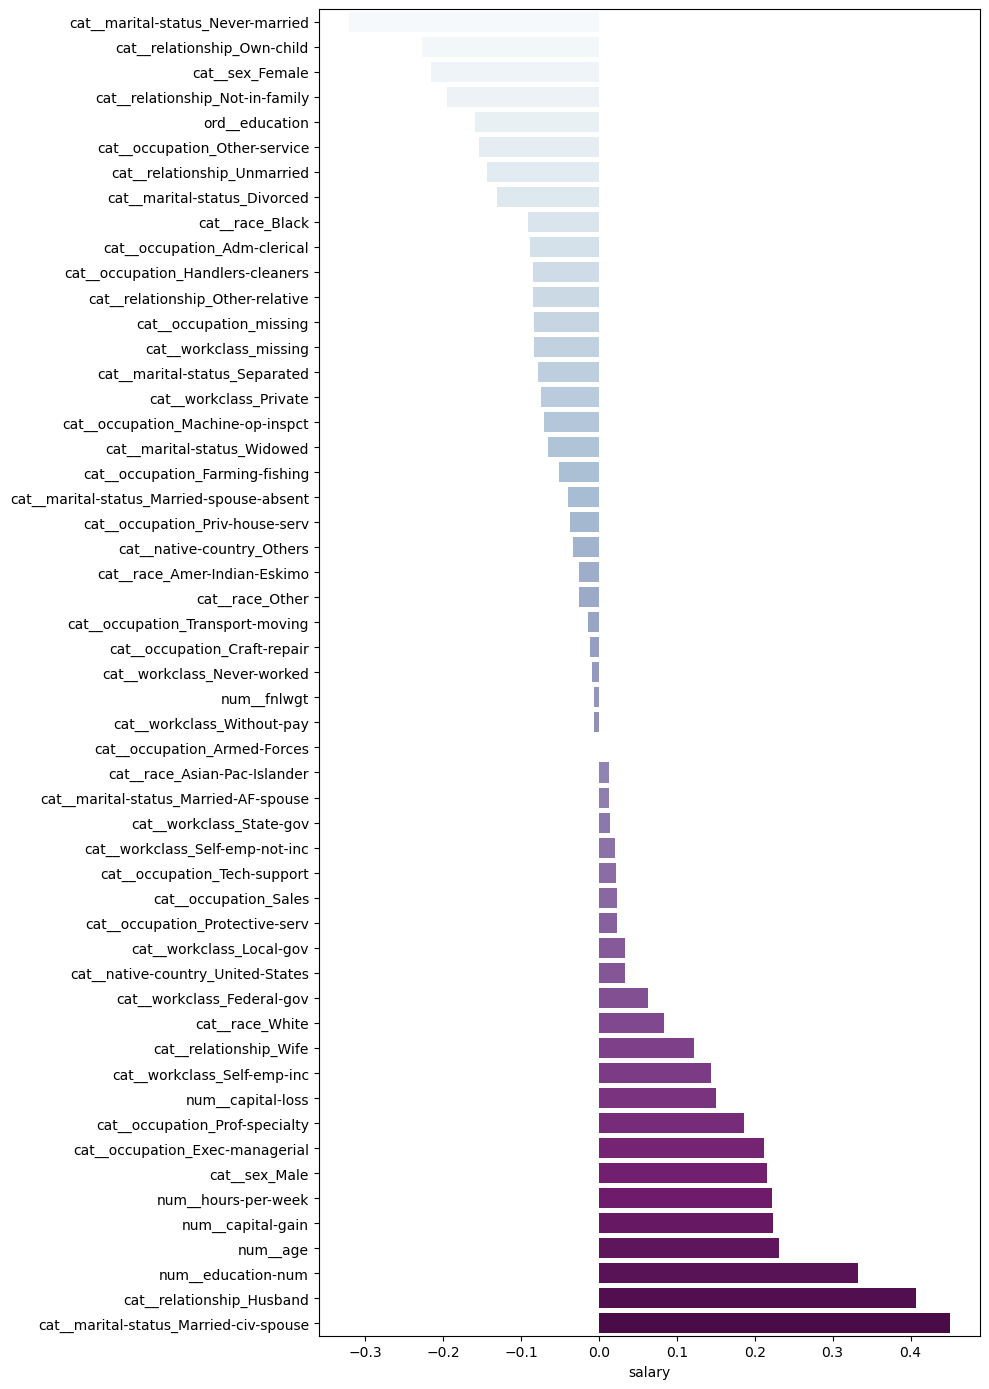

In [557]:
# Get correlation with Salary
corr_by_income = X_train_df.join(y_train).corr()["salary"].sort_values()[:-1]

# Plot so that you can also see the magnitude of the correlation
plt.figure(figsize = (10, 14))
sns.barplot(y = corr_by_income.index, x = corr_by_income, palette='BuPu')
plt.tight_layout()

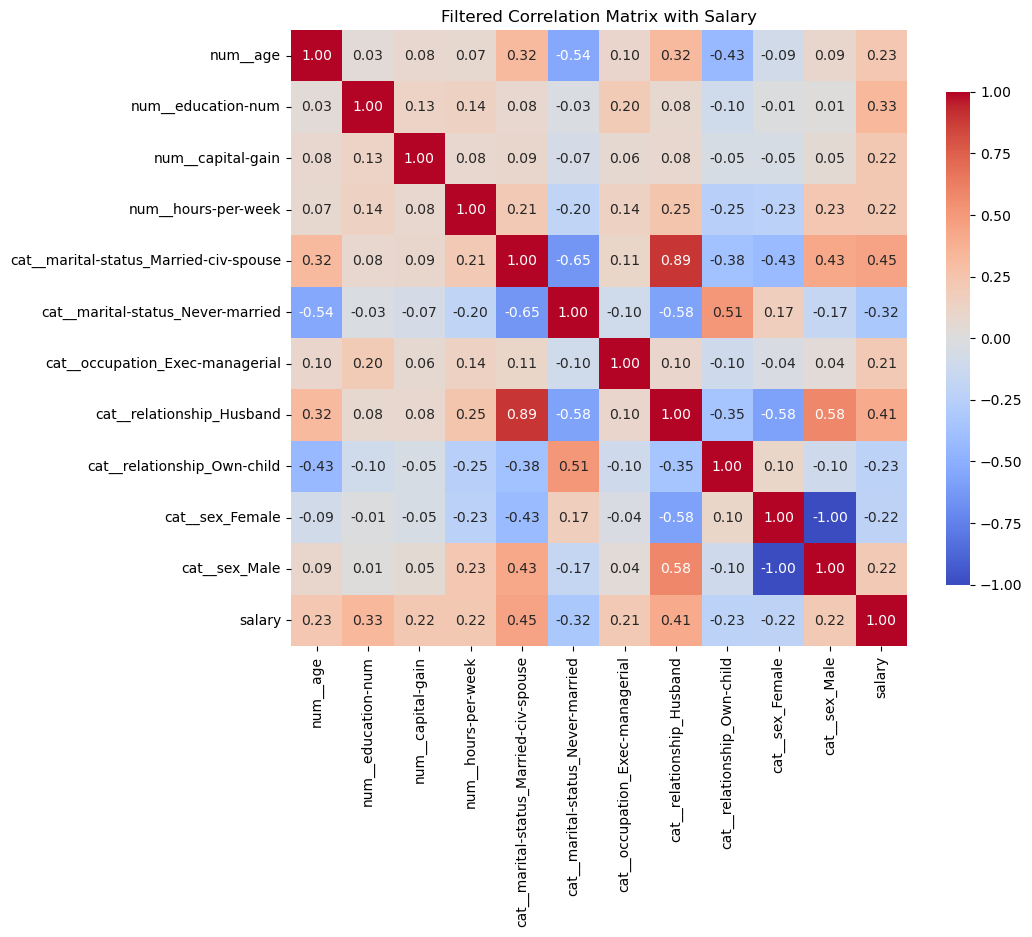

In [558]:
y_train_df = pd.DataFrame(y_train).reset_index(drop=True)

combined_train_df = pd.concat([X_train_df.reset_index(drop=True), y_train_df], axis=1)
combined_train_df.rename(columns={combined_train_df.columns[-1]: 'salary'}, inplace=True)

correlation_matrix = combined_train_df.corr()

# Set a correlation threshold, I have chosen 0.2 here based on the plot above.
threshold = 0.2

abs_corr = correlation_matrix['salary'].abs()
high_corr_features = abs_corr[abs_corr > threshold].index
filtered_corr_matrix = combined_train_df[high_corr_features].corr()

# Plot the heatmap for highest correlation features with salary
plt.figure(figsize=(10, 8))
sns.heatmap(filtered_corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Filtered Correlation Matrix with Salary')
plt.show()

### After finding the features which have a high correlation with salary, now remove all the features that have a high correlation among each other or a low one with salary

In [559]:
# Step 1: Calculate absolute correlations with the target variable 'salary'
abs_corr_with_salary = combined_train_df.corr()['salary'].abs()

# Step 2: Create a mask for features that have low correlation with 'salary'
low_corr_mask = abs_corr_with_salary < 0.15

# Step 3: Create a mask for high correlations among features
high_corr_mask = (filtered_corr_matrix.abs() > 0.5) & (filtered_corr_matrix != 1)

# Step 4: Initialize a set to keep track of features to drop
features_to_drop = set()

# Step 5: Identify features to drop based on high correlations
for i in range(len(filtered_corr_matrix.columns)):
    for j in range(i):
        if high_corr_mask.iloc[i, j]:
            # Add one of the features to the drop set
            features_to_drop.add(filtered_corr_matrix.columns[i])  # or use columns[j]

# Step 6: Add features with low correlation to the target variable
low_corr_features = abs_corr_with_salary[low_corr_mask].index.tolist()
features_to_drop.update(low_corr_features)

# Step 7: Convert set to list for easier handling
features_to_drop = list(features_to_drop)

# Step 8: Display the features to drop
print("Features to drop:", features_to_drop)

# Step 9: Drop the selected features from the original DataFrame
X_train_reduced = X_train_df.drop(columns=features_to_drop)
X_test_reduced = X_test_df.drop(columns=features_to_drop)

# Step 10: Verify the shapes of the new DataFrames
print("New X_train shape:", X_train_reduced.shape)
print("New X_test shape:", X_test_reduced.shape)


Features to drop: ['cat__occupation_Transport-moving', 'cat__occupation_Armed-Forces', 'cat__occupation_Handlers-cleaners', 'cat__workclass_Private', 'cat__relationship_Husband', 'cat__occupation_Tech-support', 'cat__marital-status_Married-AF-spouse', 'cat__workclass_Without-pay', 'cat__race_Amer-Indian-Eskimo', 'cat__workclass_Self-emp-not-inc', 'cat__occupation_Machine-op-inspct', 'cat__occupation_Sales', 'cat__marital-status_Married-spouse-absent', 'cat__relationship_Unmarried', 'num__fnlwgt', 'cat__native-country_Others', 'cat__marital-status_Separated', 'cat__race_White', 'cat__workclass_Local-gov', 'cat__occupation_Protective-serv', 'cat__relationship_Own-child', 'cat__sex_Male', 'cat__workclass_Federal-gov', 'num__capital-loss', 'cat__workclass_State-gov', 'cat__occupation_Adm-clerical', 'cat__race_Asian-Pac-Islander', 'cat__workclass_Self-emp-inc', 'cat__occupation_Farming-fishing', 'cat__relationship_Other-relative', 'cat__race_Black', 'cat__race_Other', 'cat__workclass_missin

In [560]:
X_train_reduced.head()

,num__age,num__education-num,num__capital-gain,num__hours-per-week,cat__marital-status_Married-civ-spouse,cat__occupation_Exec-managerial,cat__occupation_Other-service,cat__occupation_Prof-specialty,cat__relationship_Not-in-family,ord__education
37193,0.205479,0.533333,0.0,0.397959,1.0,0.0,0.0,0.0,0.0,3.0
31093,0.383562,0.866667,0.0,0.397959,1.0,0.0,0.0,1.0,0.0,4.0
33814,0.246575,0.466667,0.0,0.397959,1.0,0.0,0.0,0.0,0.0,5.0
14500,0.643836,0.533333,0.0,0.193878,0.0,0.0,0.0,0.0,0.0,3.0
23399,0.630137,0.533333,0.0,0.704082,0.0,0.0,0.0,0.0,1.0,3.0


In [561]:
X_train_reduced.shape, X_test_reduced.shape, y_train.shape, y_test.shape

((39073, 10), (9769, 10), (39073,), (9769,))

In [562]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


def apply_model(model, X_train, X_test, y_train, y_test):
    # Convert sparse matrix to dense format for models that do not support sparse input
    if hasattr(X_train, "toarray"):  # Check if X_train is sparse
        X_train = X_train.toarray()
        X_test = X_test.toarray()
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    return accuracy, precision, recall, f1

In [563]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

# Apply models and collect results
results_lr = apply_model(LogisticRegression(max_iter=500), X_train_reduced, X_test_reduced, y_train, y_test) 
results_rf = apply_model(RandomForestClassifier(n_estimators=100, n_jobs=-1), X_train_reduced, X_test_reduced, y_train, y_test)
results_gbm = apply_model(GradientBoostingClassifier(n_estimators=100), X_train_reduced, X_test_reduced, y_train, y_test)
results_nb = apply_model(MultinomialNB(), X_train_reduced, X_test_reduced, y_train, y_test)

# Print the results
print("Results from Logistic Regression:")
print("Accuracy:", results_lr[0])
print("Precision:", results_lr[1])
print("Recall:", results_lr[2])
print("F1 Score:", results_lr[3])
print("\n")

print("Results from Random Forest Classifier:")
print("Accuracy:", results_rf[0])
print("Precision:", results_rf[1])
print("Recall:", results_rf[2])
print("F1 Score:", results_rf[3])
print("\n")

print("Results from Gradient Boosting Classifier:")
print("Accuracy:", results_gbm[0])
print("Precision:", results_gbm[1])
print("Recall:", results_gbm[2])
print("F1 Score:", results_gbm[3])
print("\n")

print("Results from Naive Bayes Classifier:")
print("Accuracy:", results_nb[0])
print("Precision:", results_nb[1])
print("Recall:", results_nb[2])
print("F1 Score:", results_nb[3])
print("\n")

Results from Logistic Regression:
Accuracy: 0.8428703040229297
Precision: 0.8348106080771062
Recall: 0.8428703040229297
F1 Score: 0.8350449458301945


Results from Random Forest Classifier:
Accuracy: 0.8330433002354386
Precision: 0.8265150304134801
Recall: 0.8330433002354386
F1 Score: 0.8286164937063474


Results from Gradient Boosting Classifier:
Accuracy: 0.8590439144231754
Precision: 0.852962607487311
Recall: 0.8590439144231754
F1 Score: 0.852053833665897


Results from Naive Bayes Classifier:
Accuracy: 0.8111372709591566
Precision: 0.7973245244100867
Recall: 0.8111372709591566
F1 Score: 0.7885110854765827




### Label perturbation
To evaluate the impact of faulty labels in a dataset, we will introduce some errors in the labels of our data.


#### Preparation
Start by creating a method which alters a dataset by selecting a percentage of rows randomly and swaps labels from a 0->1 and 1->0. 


In [564]:
def perturbate(y, fraction):
    y_array = y.to_numpy()
    n_flips = int(len(y_array) * fraction)
    indices_to_flip = np.random.choice(len(y_array), size=n_flips, replace=False)
    y_array[indices_to_flip] = 1 - y_array[indices_to_flip]

    return y_array

#### Evaluate Models

In [565]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=500),
    'Random Forest': RandomForestClassifier(n_estimators=100, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100),
    'Naive Bayes': MultinomialNB()
}

In [566]:
def evaluate_models_on_perturbed_data(X_train, X_test, y_train, y_test, models, n_runs=1):
    results = {}
    
    for model_name, model in models.items():
        results[model_name] = {
            'original': [],
            'perturbed_0.1': [],
            'perturbed_0.2': [],
            'perturbed_0.3': [],
            'perturbed_0.4': [],
            'perturbed_0.5': []
        }
        
        for _ in range(n_runs):
            # Original accuracy
            accuracy = apply_model(model, X_train, X_test, y_train, y_test)[0]
            results[model_name]['original'].append(accuracy)
            
            # Perturbed accuracies
            for fraction in [0.1, 0.2, 0.3, 0.4, 0.5]:
                perturbed_y = perturbate(y_train, fraction)
                perturbed_accuracy = apply_model(model, X_train, X_test, perturbed_y, y_test)[0]
                results[model_name][f'perturbed_{fraction}'].append(perturbed_accuracy)
    
    # Calculate mean and variance for each model and perturbation level
    for model_name, metrics in results.items():
        for key in metrics:
            metrics[key] = (np.mean(metrics[key]), np.var(metrics[key]))
    
    return results

In [567]:
def visualize_results(results):
    perturbation_levels = ['original', 'perturbed_0.1', 'perturbed_0.2', 'perturbed_0.3', 'perturbed_0.4', 'perturbed_0.5']
    
    plt.figure(figsize=(12, 6))

    for model_name, metrics in results.items():
        accuracies = [metrics[key][0] for key in perturbation_levels]  # Get mean accuracy
        variances = [metrics[key][1] for key in perturbation_levels]    # Get variance

        # Calculate standard deviation for error bars
        std_devs = np.sqrt(variances)

        plt.errorbar(perturbation_levels, accuracies, yerr=std_devs, label=model_name, capsize=5, marker='o')

    plt.title('Model Performance on Perturbed Data')
    plt.xlabel('Perturbation Level')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

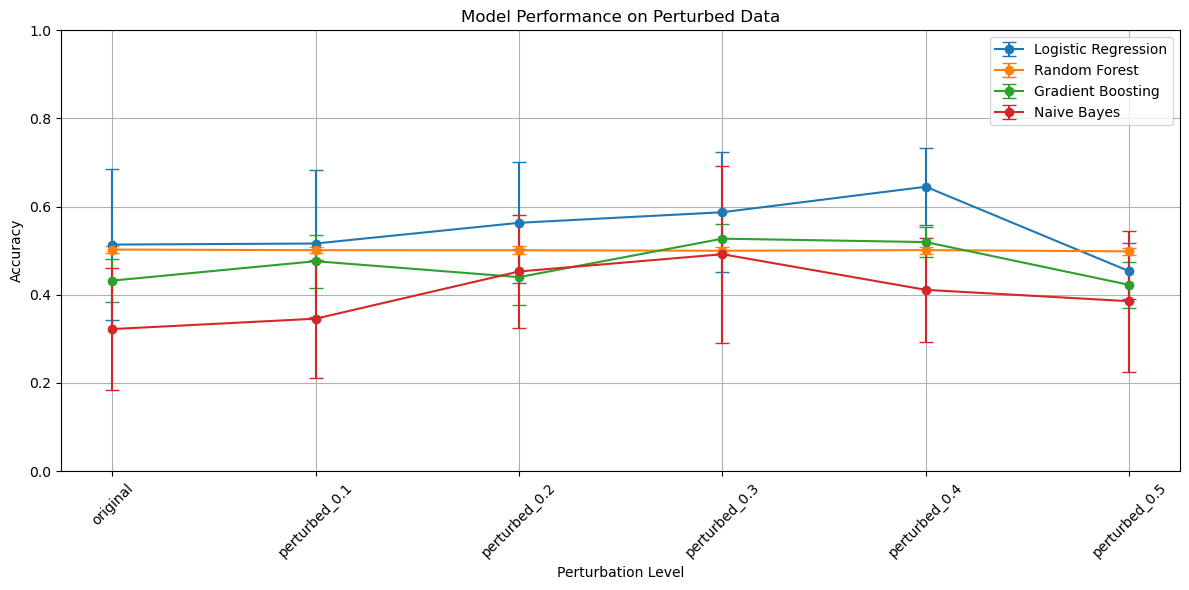

In [568]:
results = evaluate_models_on_perturbed_data(X_train_reduced, X_test_reduced, y_train, y_test, models, n_runs=5)

# Visualize the results
visualize_results(results)

#### Visualizing results

Observations + explanations: max. 400 words

#### Discussion

1)  Discuss how you could reduce the impact of wrongly labeled data or correct wrong labels. <br />
    max. 400 words



    Authors: Youri Arkesteijn, Tim van der Horst and Kevin Chong.


## Machine Learning Workflow

From part 1, you will have gone through the entire machine learning workflow which are they following steps:

1) Data Loading
2) Data Pre-processing
3) Machine Learning Model Training
4) Machine Learning Model Testing

You can see these tasks are very sequential, and need to be done in a serial fashion. 

As a small perturbation in the actions performed in each of the steps may have a detrimental knock-on effect in the task that comes afterwards.

In the final part of Part 1, you will have experienced the effects of performing perturbations to the machine learning model training aspect and the reaction of the machine learning model testing section.

## Part 2 Data Discovery

Now we have a some datasets that are related to each other.

**Altogether they are the same as the adult dataset used in the part 1 of the assignment.**

In this scenario, one can see the utility of the subsets of data can impact the outcome of the task from the previous section.

Because the data is split up, we want to be able to re-construct the data through data discovery.

As data discovery will allow you to be able to find relations that can be used to reconstruct the entire dataset.

Implement a method of your choice to perform the data discovery to be able to recover the entire dataset from part 1 of the assignment.

In [ ]:
def discovery_algorithm():
    """Function should be able to perform data discovery to find related datasets
    Possible Input: List of datasets
    Output: List of pairs of related datasets
    """

    pass

In [ ]:
## Do some testing using different degrees of relations on the downstream task.
##



### Evaluation

Following the same workflow as Part 1 of the assignment, you will need to perform the steps once again.
This means that with the difference in setting, there has now been a change in the data loading portion of the workflow. 

<!-- While performing data discovery, one can check how having more data of different relations can effect the outcome of the downstream task. -->

As you perform the act of data discovery you will be piecing the data back together one by one by finding the relation between the datasets.

As you piece the data back together, the entire dataset will be available in varying portions.

Then using the different portions of available data, fit the models that were used previously, and examine the results when testing on the appropriate data from the testing samples.

*The dataset from part 1 can be treated as the groundtruth, so you can try and random sample from that dataset to produce the testing samples that can be used in this part.* 

***

One can also evaluate on the effect of incorrectness of data discovery.

Suppose what you have done for data discovery is correct, this means the relations that are found are correct.

What if you perform a perturbation on the relations between the files? 

This would mean the dataset will be incorrectly joined, do you think there will be an impact on the outcome of the model that will be trained and then tested on the groudtruth dataset?

What would the effect be on the downstream tasks as mentioned in the machine learning workflow such as data pre-processing, machine learning model training and testing?

This can be evaluated in the same way as above.

In [ ]:
## Do some testing on performing various degrees of incorrect data discovery.
##

## Discussions

1)  Discuss the different effects of the results of the data discovery results on various downstream tasks in the machine learning workflow.
    As stated previously, this is effecting the data loading portion of the ML workflow.

2)  Discuss also what aspects need to be considered when performing data discovery and evaluating the results of data discovery.

Max. 400 words

The perturbations that performed for part 1 and 2 are all data quality issues.

3) Discuss on the effects of data quality and how you may attempt to identify and solve these issues?

<!-- For the set of considerations that you have outlined for the choice of data discovery methods, choose one and identify under this new constraint, how would you identify and resolve this problem? -->

Max 400 words